# Norms and Weight Decay

The most common method for ensuring a small weight vector is to add its norm as a penalty term to the problem of minimizing the loss. 
Thus we replace our original objective, minimizing the prediction loss on the training labels, with new objective, 
minimizing the sum of the prediction loss and the penalty term.

Now, if our weight vector grows too large, our learning algorithm might focus on minimizing the weight norm 
vs. minimizing the training error. That is exactly what we want. To illustrate things in code, we revive our previous example 
from Section 3.1 for linear regression. There, our loss was given by:
      

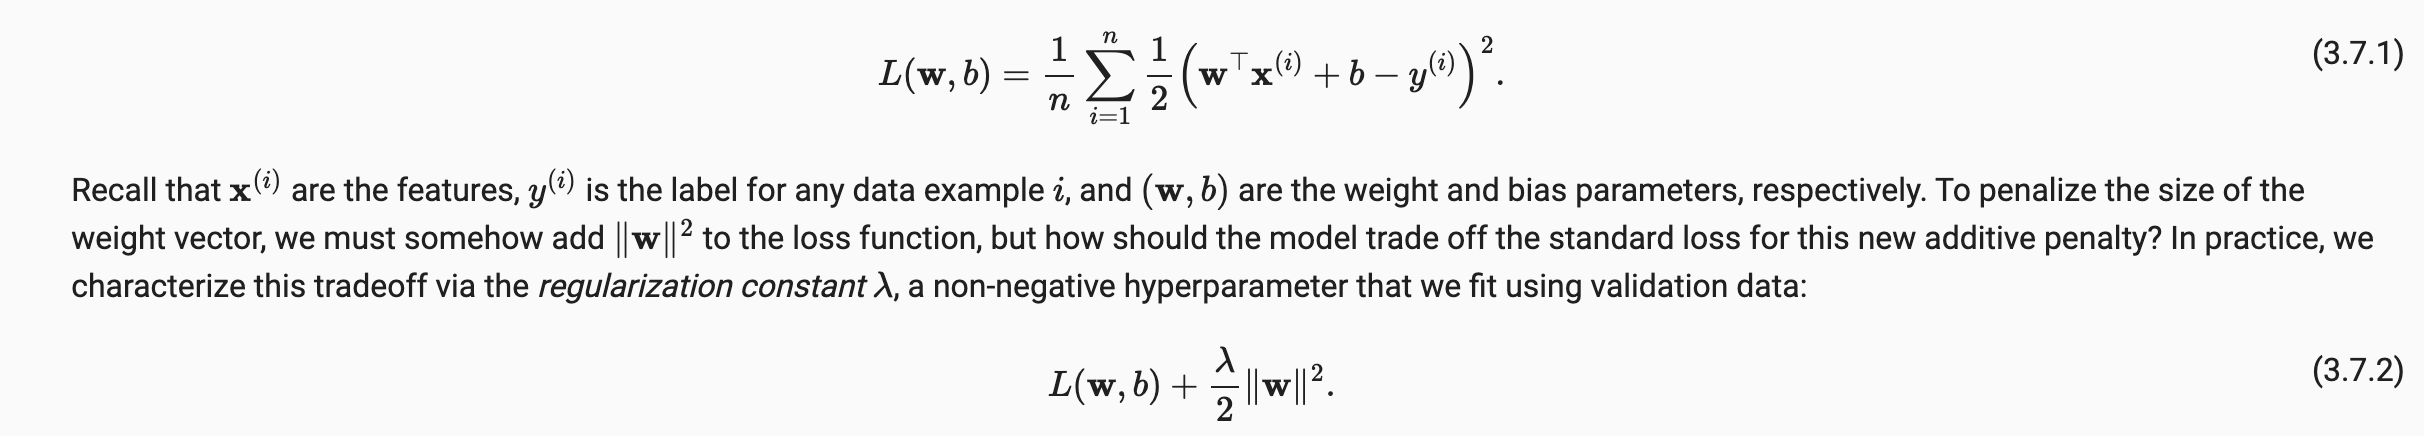

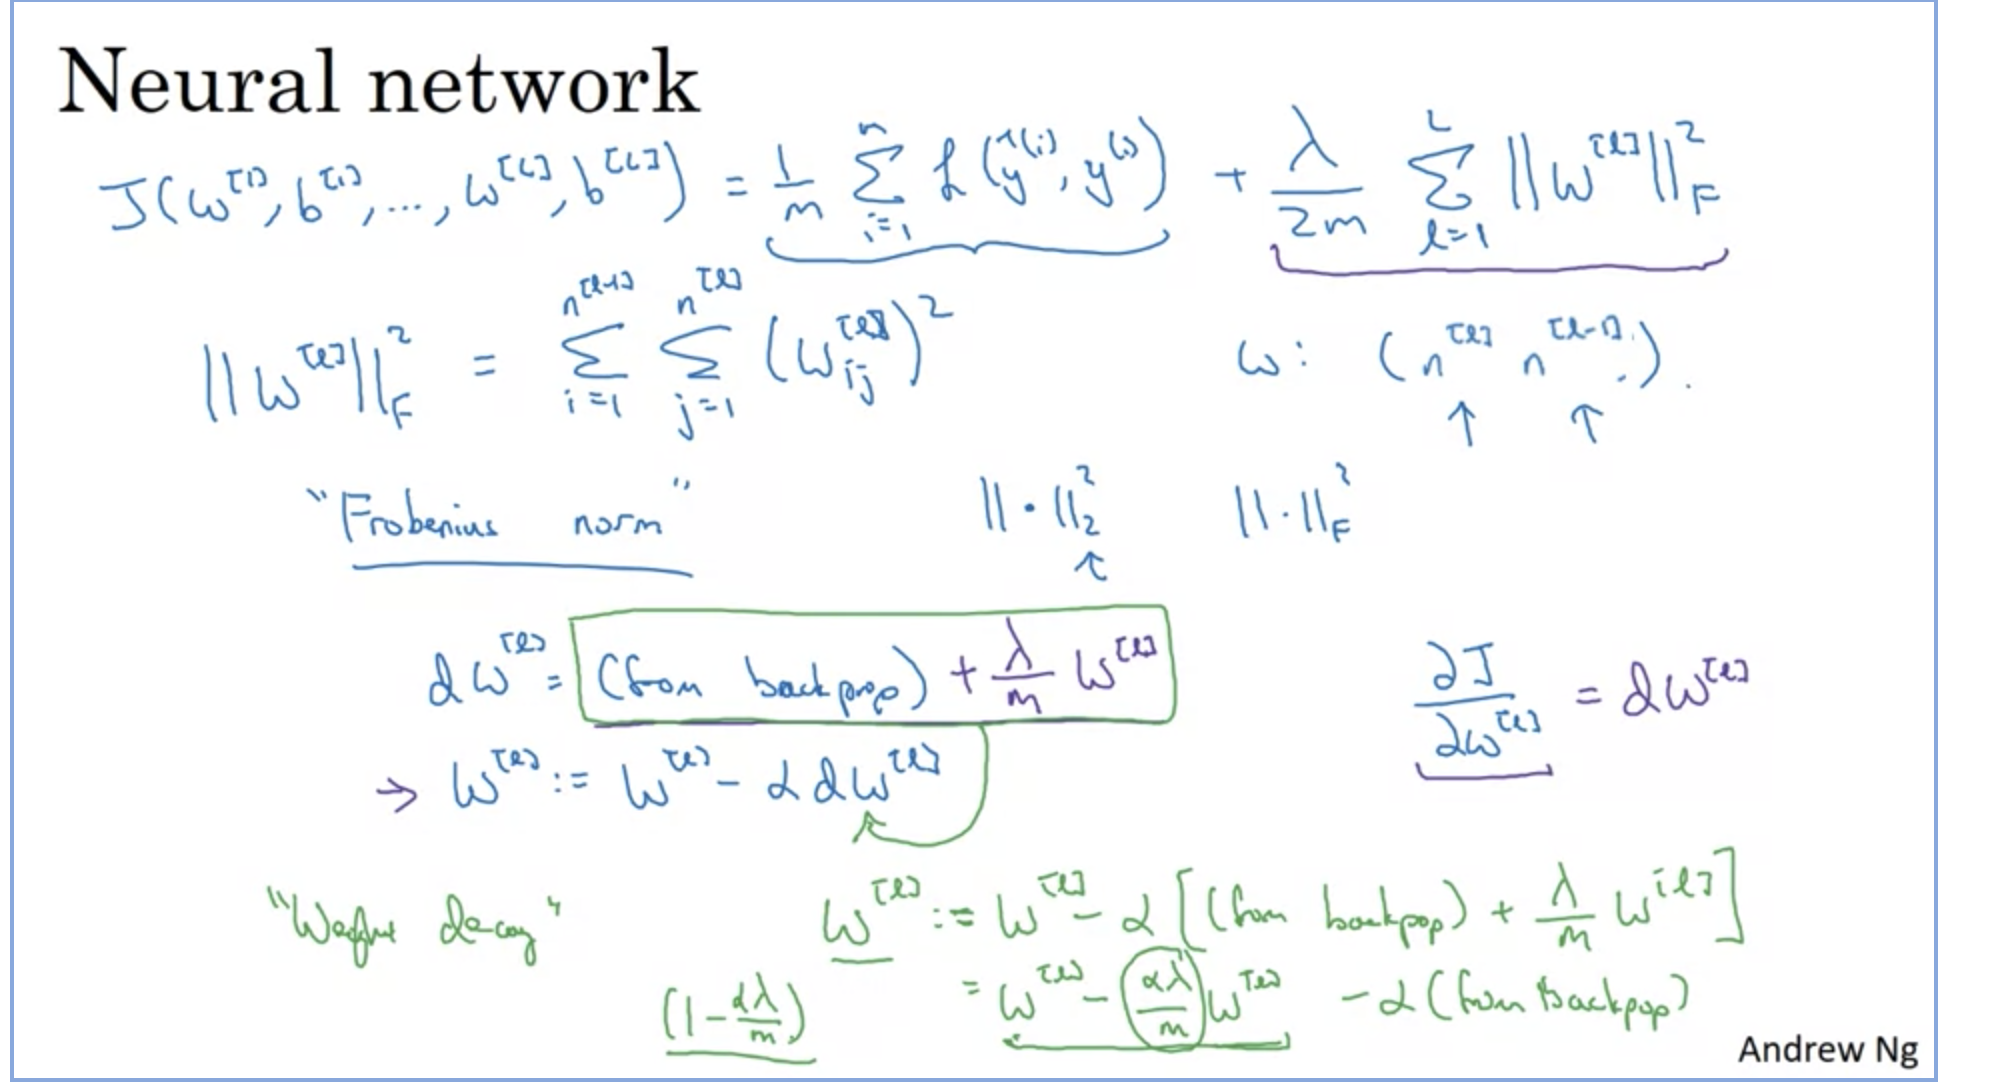

# We can illustrate the benefits of weight decay through a simple synthetic example.

In [22]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

In [23]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = tf.random.normal((n, num_inputs))
        noise = tf.random.normal((n, 1)) * 0.01
        w, b = tf.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = tf.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)
    
def l2_penalty(w):
    return tf.reduce_sum(w**2) / 2

class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [24]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

In [25]:
def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

# Training without Regularization
We now run this code with lambd = 0, disabling weight decay. Note that we overfit badly, decreasing the training error 
but not the validation error—a textbook case of overfitting.

L2 norm of w: 0.009536799043416977


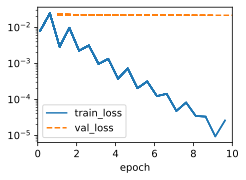

In [26]:
train_scratch(0)

# Using Weight Decay
Below, we run with substantial weight decay. 
Note that the training error increases but the validation error decreases. This is precisely the effect we expect from regularization.

L2 norm of w: 0.0013289081398397684


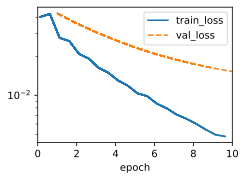

In [27]:
train_scratch(3)

# Concise Implementation

In [28]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.net = tf.keras.layers.Dense(
            1, kernel_regularizer=tf.keras.regularizers.l2(wd),
            kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.01)
        )

    def loss(self, y_hat, y):
        return super().loss(y_hat, y) + self.net.losses

L2 norm of w: 0.0005747042596340179


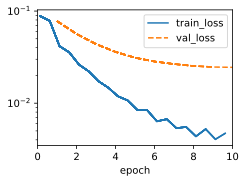

In [29]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))


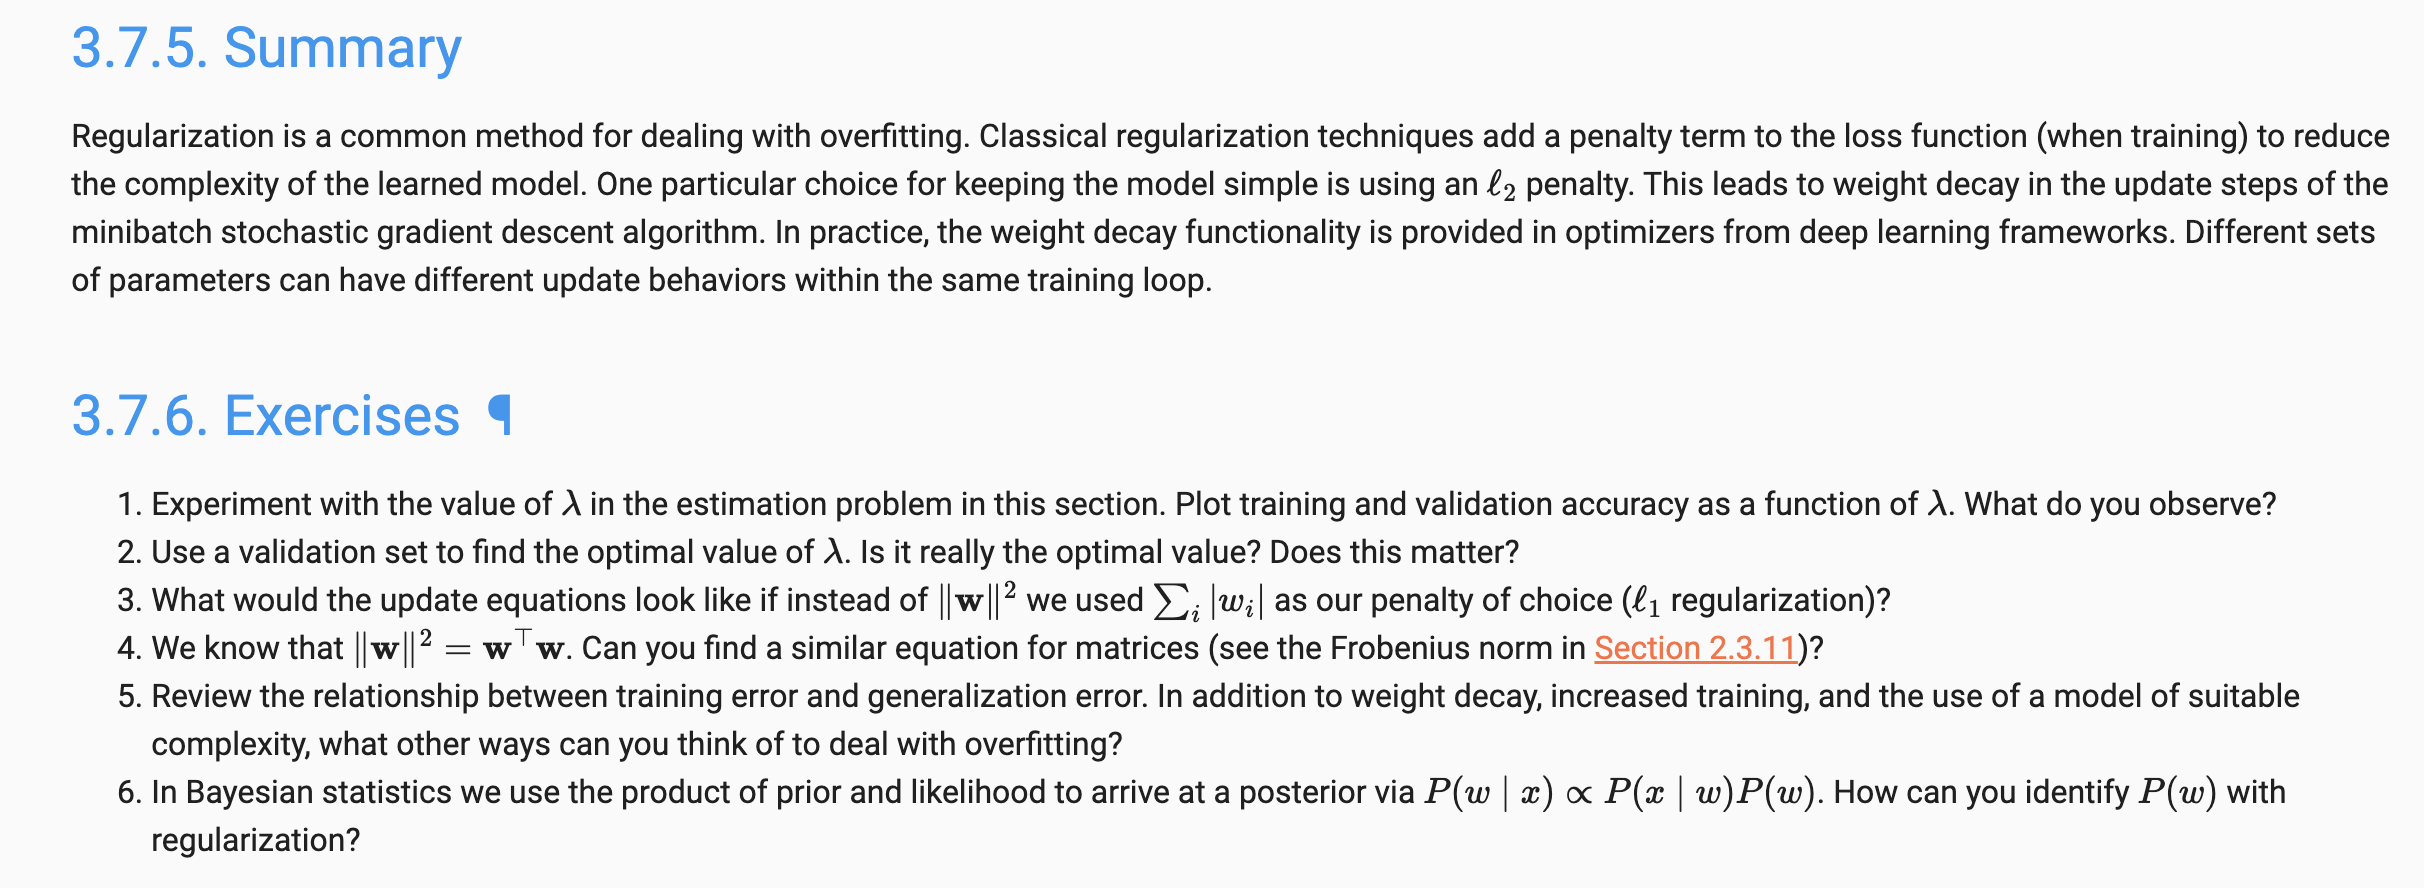

# Dropout
dropout, involves injecting noise while computing each internal layer during
forward propagation, and it has become a standard technique for training neural networks. The
method is called dropout because we literally drop out some neurons during training. Throughout
training, on each iteration, standard dropout consists of zeroing out some fraction of the nodes in
each layer before calculating the subsequent layer.

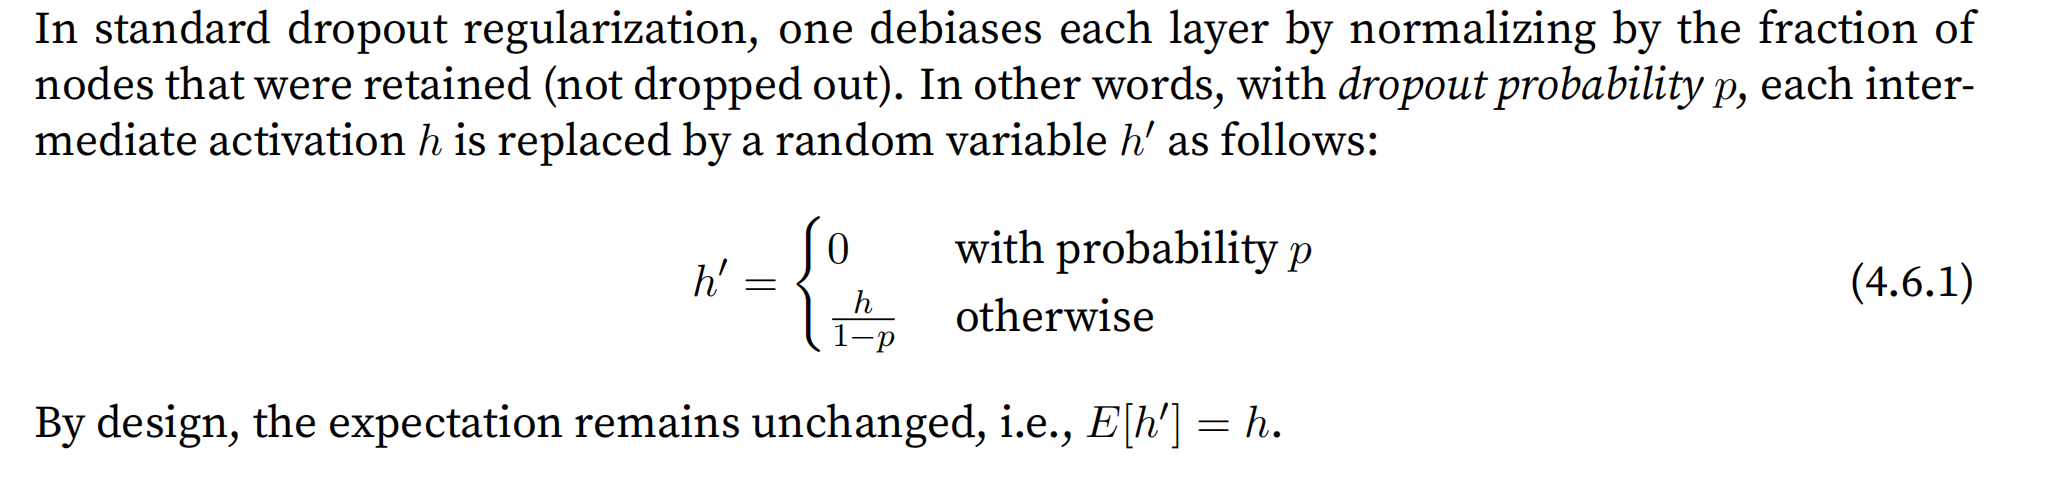


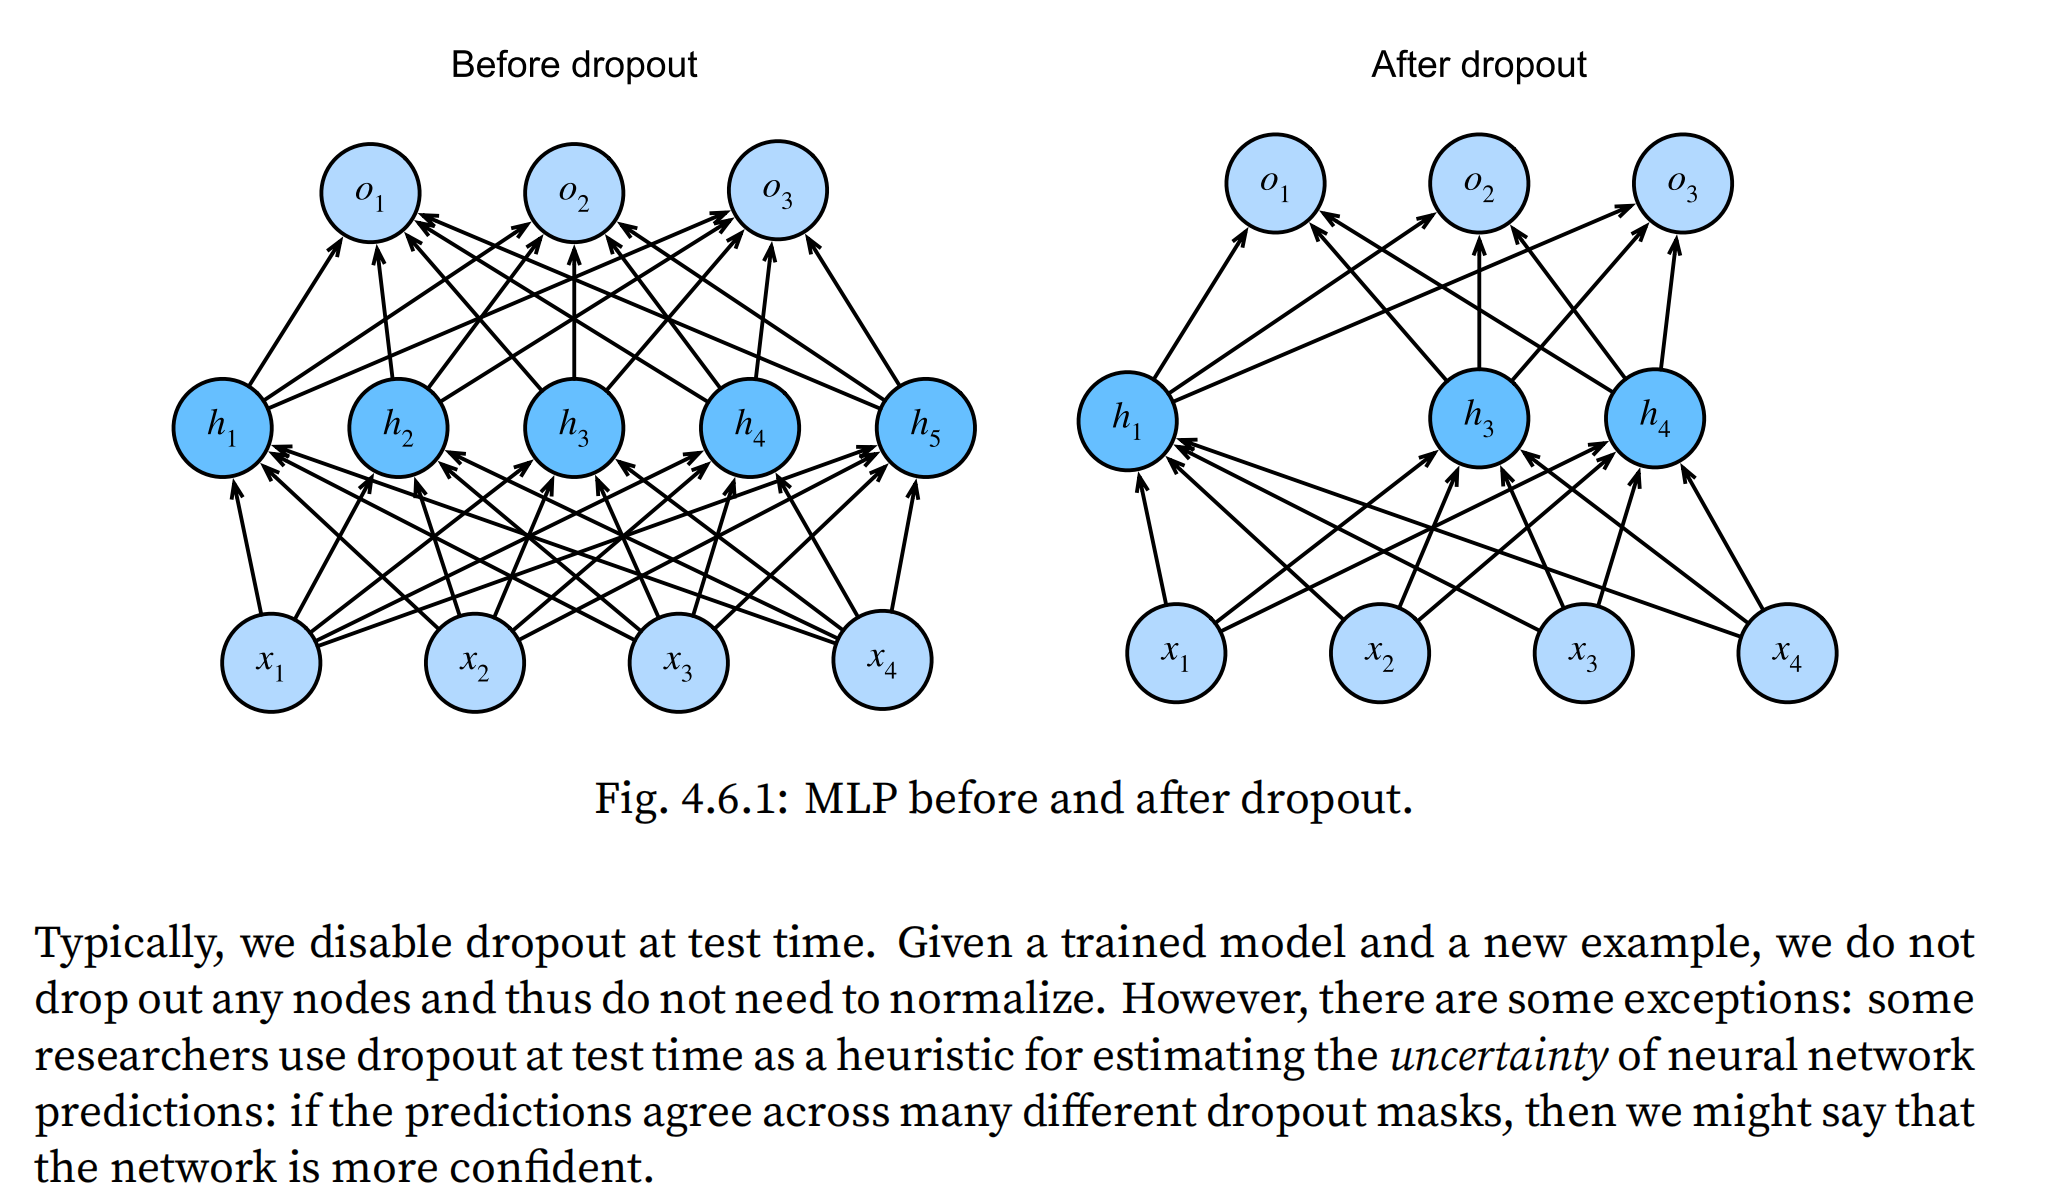

In [30]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return tf.zeros_like(X)
    mask = tf.random.uniform(
        shape=tf.shape(X), minval=0, maxval=1) < 1 - dropout
    return tf.cast(mask, dtype=tf.float32) * X / (1.0 - dropout)

In [31]:
X = tf.reshape(tf.range(16, dtype=tf.float32), (2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
dropout_p = 0.5: tf.Tensor(
[[ 0.  0.  4.  6.  0.  0. 12. 14.]
 [ 0.  0.  0.  0. 24. 26.  0. 30.]], shape=(2, 8), dtype=float32)
dropout_p = 1: tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


In [32]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = tf.keras.layers.Dense(num_hiddens_1, activation='relu')
        self.lin2 = tf.keras.layers.Dense(num_hiddens_2, activation='relu')
        self.lin3 = tf.keras.layers.Dense(num_outputs)

    def forward(self, X):
        H1 = self.lin1(tf.reshape(X, (X.shape[0], -1)))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.lin2(H1)
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

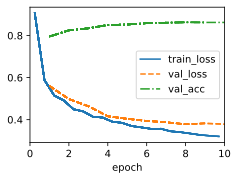

In [33]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

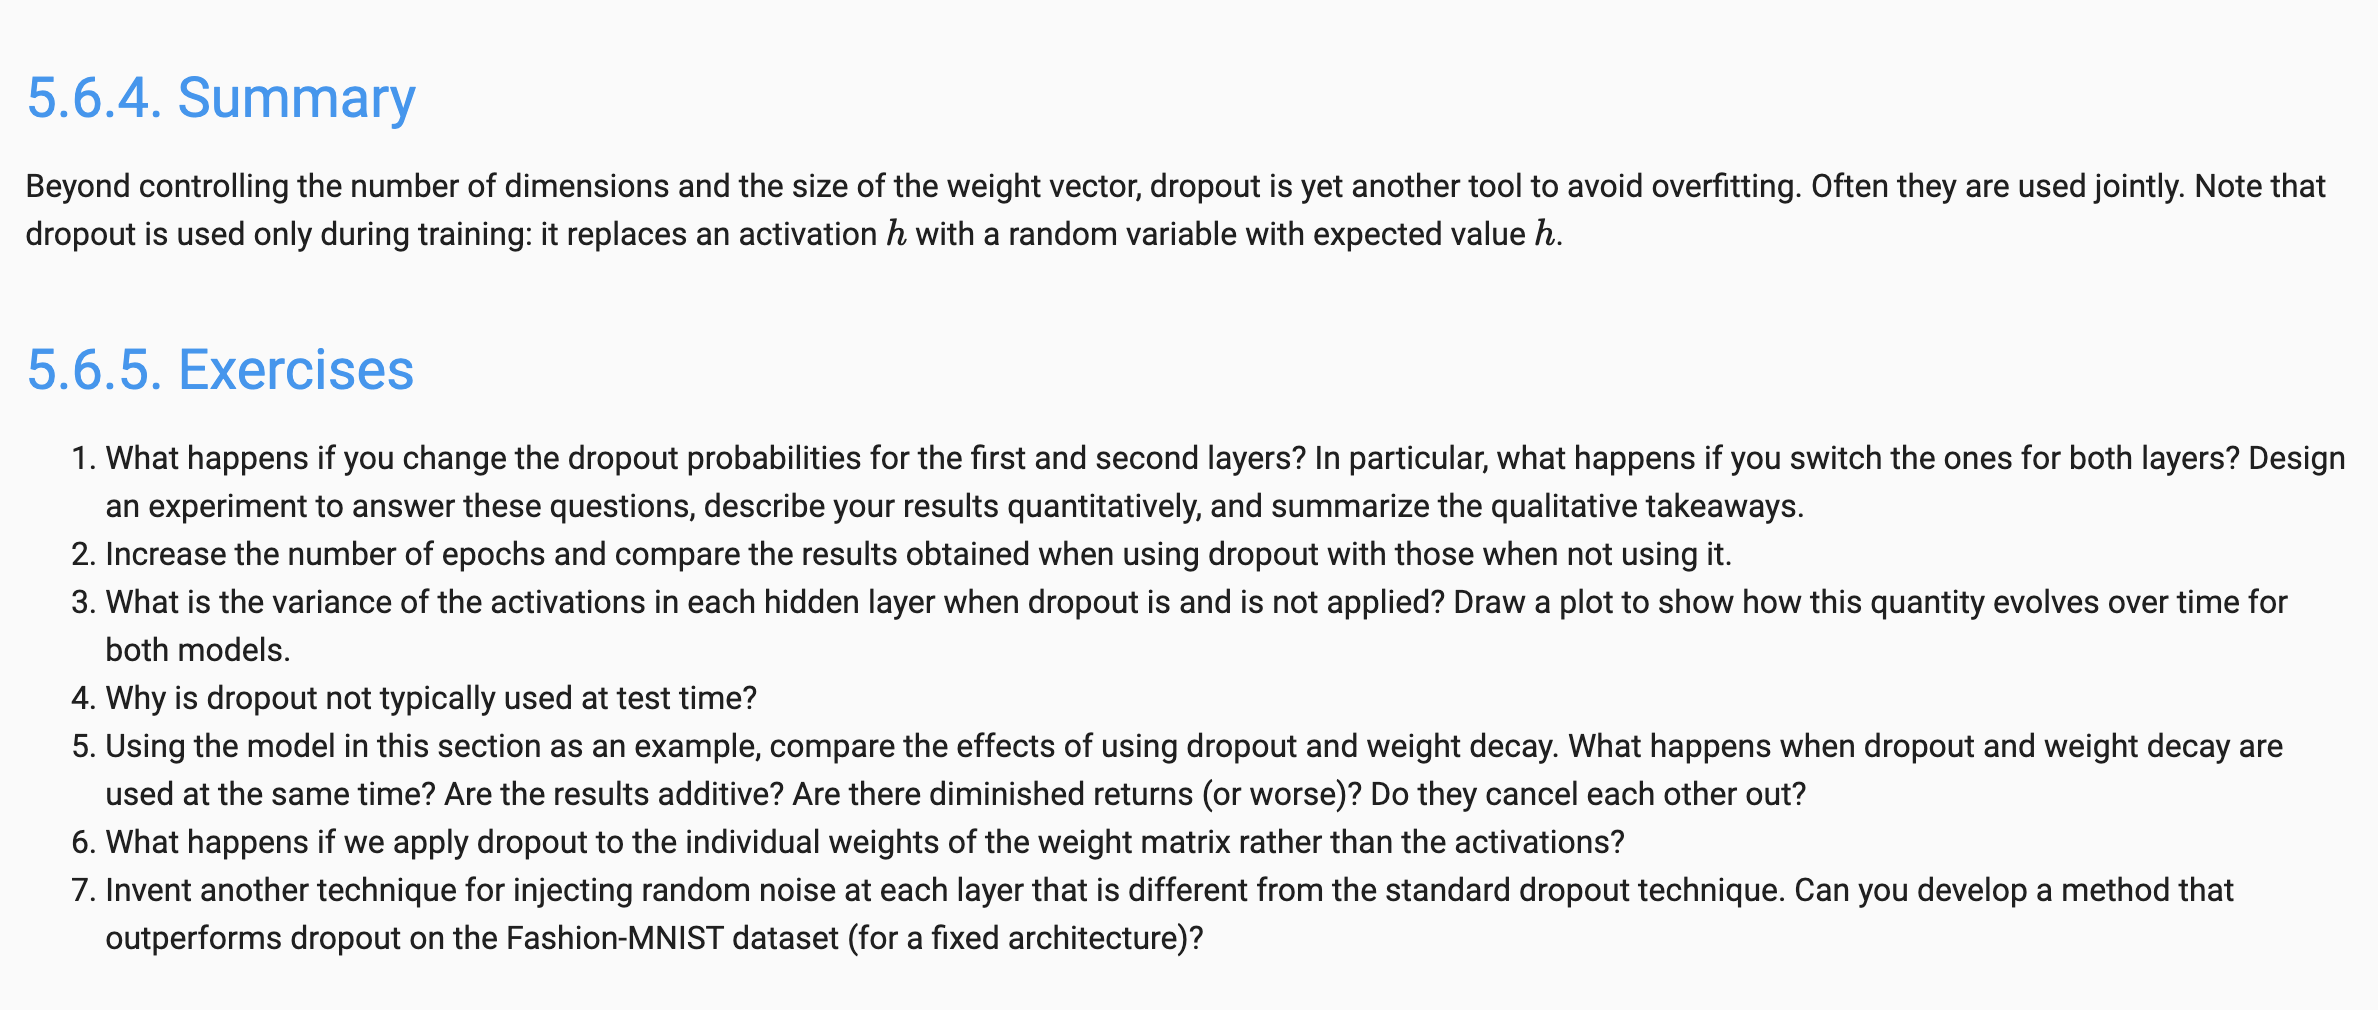